# Actividad 3 INFO183

#### Instrucciones generales

- Complete este cuadernillo jupyter con sus códigos y respuestas
- Se trabajará en grupos de tres personas
- Se entrega un cuadernillo por grupo
- La entrega es a través de correo electrónico a phuijse@inf.uach.cl
- La fecha de entrega es el Lunes 6 de Abril a las 23:59
- Use las librerías `scipy`, `numpy` y `matplotlib`

### Nombre completo de los integrantes: 
- Francisco Levin
- Gonzalo Silva
- Rodrigo Zambrano

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np

%matplotlib notebook
from IPython.display import display, Audio, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import soundfile as sf
import scipy.signal
%matplotlib notebook
from matplotlib import animation, patches
from style import *


NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

Cannot find path /home/phuijse/.jupyter/nbconfig/, rise configuration wasn't set


#### Enunciado

En esta tarea se pide entrenar y evaluar un predictor para la serie de tiempo Mackey-Glass. Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = 0.2 \frac{ y(t-\tau)}{1 + y(t-\tau)^{10}} - 0.1 y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

***

Use el código que se muestra a continuación para generar la serie de tiempo Mackey Glass

- Considere una razón señal a ruido (SNR) de 2.
- Considere $\tau=17$ (comportamiento debilmente caótico)

Se generaran 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar y los siguientes 500 puntos para hacer predicción

<IPython.core.display.Javascript object>


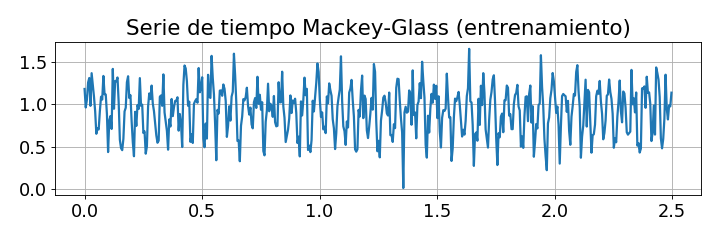

In [2]:
# número de observaciones (no modificar)
N = 1000
# Razón señal a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuación diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento dinámico de Mackey-Glass (17, 30)
tau = 17.
# paso de integración (no modificar)
dt = 0.05
# condición incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

***

1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener
1. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos
1. La siguiente clase de *Python* predice y entrena un filtro LMS. Complete la línea que dice 

` self.w = ? `

con el valor correcto de actualización de peso del filtro LMS

# Desarrollo
1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener

 - El algoritmo LMS es usado en filtros adaptativos, para encontrar el filtro que permiten obtener el valor esperado mínimo del cuadrado de la señal de error, que es considerada como la diferencia entre la señal deseada y la señal producida a la salida del filtro. 

    - Pertenece a la familia de algoritmos de gradiente estocástico. 
        Es un algoritmo facil de implementar, ya que no requiere medidas tales como la inversión de la matriz de correlación ni funciones de correlación. 

    El algoritmo LMS es un algoritmo de filtrado lineal adaptativo, que, en general, consiste de dos fases: 
    - Proceso de filtrado (Computo de la salida de un filtro en función de su entrada y estimaciones de error)
    - Proceso adaptativo (Ajuste automático de los parametros del filtro de acuerdo a su estimación de error). 

    SEMEJANZAS:

    - El algoritmo LMS converge con la solución del filtro de Wiener, suponiendo que el sistema desconocido es LTI y el sistema es estacionario. 

    - Los dos filtros sirven para identificar la respuesta a un sistema desconocido, conociendo solo la señal de entrada original y la salida del sistema desconocido. 

    DIFERENCIAS: 

    - El filtro de Wiener se parece mucho a la estimación de minimos cuadrados, excepto en el dominio de procesamiento de señales.
    - A diferencia del filtro de Wiener no se require conocimiento estadistico del proceso. 
    - LMS se actualiza online y tiene costo $L$. Wiener se entrena offline y tiene costo $L^2$.
    - En el algoritmo LMS no se requiere invertir la matriz de correlación.
    - Wiener es optimo mientras que LMS es sub-optimo. 
    
1. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos
$$
\begin{align}
J^s_n(\textbf{w}) &= e_n^2 \nonumber \\
&= (d_n - y_n)^2 \nonumber \\
&= (d_n - \textbf{w}^T \textbf{u}_n )^2 \nonumber \\
&= (d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k} )^2 \nonumber 
\end{align}
$$
El gradiente en funcion a sus pesos es
$$
\frac{d J^s_n (\textbf{w})}{d w_{n, k}} = - 2 e_n u_{n-k}
$$
Usando la regla SGD llegamos a 
$$
w_{n+1, k} = w_{n, k} + 2 \mu e_n u_{n-k}, k=0, 1, \ldots, L
$$
o en forma matricial
$$
\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e_n \textbf{u}_{n}\nonumber \\
&= \textbf{w}_{n} + 2 \mu (d_n -  \textbf{w}_{n}^T \textbf{u}_{n}) \textbf{u}_{n}, \nonumber 
\end{align}
$$




In [4]:
class LMS_filter(object):
    
    def __init__(self, L=1, mu=0.5, normalized=True):
        self.L = L
        self.mu = mu
        self.w = np.zeros(shape=(L, ))
        self.normalized = normalized
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):
        d_pred = self.predict(u)
        norm = 1.
        if self.normalized:
            norm = np.sum(u**2) + 1e-6
        self.w = self.w + 2*self.mu*(d -d_pred)*u/norm #se agrego 2*self.mu*(d -d_pred)*u/norm 


***
## Predicción con algoritmo LMS

1. Entrene el predictor con el algoritmo normalized LMS usando el siguiente bloque de código
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\mu$ y $L$
    - Se recomienda hacer un barrido logarítmico en $\mu$ (por ejemplo `mu=np.logspace(-2, 0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
***

1. Repita el experimento para $\tau = 30$ (comportamiento fuertemente caótico) 
1. Compare los resultados obtenidos con cada serie de tiempo. ¿Qué casos son más sencillos y cuales más complicados?


In [6]:
#Cuando Tau es 17

N = 1000;SNR = 2.;a, b = 0.1, 0.2;tau = 17.;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

def update(L, mu):
    lms = LMS_filter(L, mu, normalized=True)
    
    # Entrenamiento
    y_pred = np.zeros(shape=(len(y_obs), ))
    for k in range(lms.__len__(), 500):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)
        lms.update(d=y_obs[k], u=y_window)
        
    # Prueba
    for k in range(500, len(y_obs)):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)

    print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
    fig, ax = plt.subplots(3, figsize=(12, 10), tight_layout=True)
    ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
    ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
    ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
    ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

    ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
    ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

interact(update, L=SelectionSlider_nice(options=[5, 10, 20, 30], value=5), mu=np.logspace(-2,0,num=20));


interactive(children=(SelectionSlider(continuous_update=False, description='L', layout=Layout(height='20px', w…

In [5]:
N = 1000;SNR = 2.;a, b = 0.1, 0.2;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
LV = [5,10,20,30];muV = np.logspace(-2, 0, num=20)
tau=17;
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

#For para L=5,10,20,30
for j in range(0,4):
    print("------------------------------------------------------------------")  
    print("L = ",LV[j])
    print("------------------------------------------------------------------")  
    #For para cada valor de mu
    for u in range(0,20):
        lms = LMS_filter(LV[j], muV[u], normalized=True)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(lms.__len__(), 500):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
            lms.update(d=y_obs[k], u=y_window)
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
        print("mu = ", muV[u],"         MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
   

------------------------------------------------------------------
L =  5
------------------------------------------------------------------
mu =  0.01          MSE entrenamiento 1227.8754, prueba 772.8594
mu =  0.012742749857031334          MSE entrenamiento 1136.9204, prueba 737.4738
mu =  0.016237767391887217          MSE entrenamiento 1058.8728, prueba 699.6373
mu =  0.0206913808111479          MSE entrenamiento 990.5780, prueba 660.8372
mu =  0.026366508987303583          MSE entrenamiento 930.7635, prueba 622.7582
mu =  0.03359818286283781          MSE entrenamiento 879.2813, prueba 587.1804
mu =  0.04281332398719394          MSE entrenamiento 836.2880, prueba 555.9065
mu =  0.0545559478116852          MSE entrenamiento 801.8955, prueba 530.8906
mu =  0.06951927961775606          MSE entrenamiento 776.4186, prueba 514.4887
mu =  0.08858667904100823          MSE entrenamiento 760.8722, prueba 509.4670
mu =  0.11288378916846889          MSE entrenamiento 757.2789, prueba 518.4717
m

# ANALISIS LMS

### Para $\tau = 17$

### L = 5
- Este filtro posee el peor sobreajuste de entrenamiento de todos con un valor maximo de MSE = 123371.8084, con respecto a la estabilidad se mantiene bien hasta aproximadamente μ = 0.297635 donde empieza a perder su estabilidad.

### L = 10
- El ajuste mejora notoriamente con respecto al anterior, mantiene el ajuste durante la mayoria de los μ que se analizaron hasta que llega a los ùltimos de estos, donde se puede observar que tiene un drastico cambio en su estabilidad y ajuste. Este cambio también se puede deducir revisando los últimos valores obtenidos en el MSE de prueba, obteniendo el valor mas alto dentro del analisis con MSE de prueba = 249576.5250.

### L = 20
- Se observa una clara estabilidad y un ajuste bastante cercano a lo que se busca, en relacion a sus valores de MSE de entrenamiento y de prueba tiene valores un poco mas bajo que los del L=10 a excepción de los últimos donde se nota una diferencia notoria de que se reducio el error bastante. El MSE de entreamiento en L=10 y con μ = 1.0 es de 46336.2213 en cambio en L = 20(μ=1.0) se obtiene MSE de entrenamiento = 6312.3703.

### L = 30
- Es el que presenta mejor ajuste y estabilidad de todos, obteniendo también los valores mas bajo en MSE de entrenamiento y de prueba con: MSE de entrenamiento = 271.9124 (μ=0.23357214690901212) y MSE de prueba = 187.9156 (μ=0.08858667904100823).

#### Indique que combinación obtiene menor MSE de prueba:
- La combinacion con menor MSE de prueba es con L=30 y μ=0.08858667904100823 obteniendo 187.9156.

In [14]:
#Cuando Tau es 30

N = 1000;SNR = 2.;a, b = 0.1, 0.2;tau = 30.;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

def update(L, mu):
    lms = LMS_filter(L, mu, normalized=True)
    
    # Entrenamiento
    y_pred = np.zeros(shape=(len(y_obs), ))
    for k in range(lms.__len__(), 500):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)
        lms.update(d=y_obs[k], u=y_window)
        
    # Prueba
    for k in range(500, len(y_obs)):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)

    print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
    fig, ax = plt.subplots(3, figsize=(12, 10), tight_layout=True)
    ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
    ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
    ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
    ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

    ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
    ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

interact(update, L=SelectionSlider_nice(options=[5, 10, 20, 30], value=5), mu=np.logspace(-2,0,num=20));

interactive(children=(SelectionSlider(continuous_update=False, description='L', layout=Layout(height='20px', w…

In [5]:
N = 1000;SNR = 2.;a, b = 0.1, 0.2;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
LV = [5,10,20,30];muV = np.logspace(-2, 0, num=20)
tau=30;
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

#For para L=5,10,20,30
for j in range(0,4):
    print("------------------------------------------------------------------")  
    print("L = ",LV[j])
    print("------------------------------------------------------------------")  
    #For para cada valor de mu
    for u in range(0,20):
        lms = LMS_filter(LV[j], muV[u], normalized=True)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(lms.__len__(), 500):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
            lms.update(d=y_obs[k], u=y_window)
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
        print("mu = ", muV[u],"         MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
   
        

------------------------------------------------------------------
L =  5
------------------------------------------------------------------
mu =  0.01          MSE entrenamiento 757.4389, prueba 484.9377
mu =  0.012742749857031334          MSE entrenamiento 703.7113, prueba 468.7517
mu =  0.016237767391887217          MSE entrenamiento 657.6870, prueba 451.3337
mu =  0.0206913808111479          MSE entrenamiento 617.5358, prueba 433.0441
mu =  0.026366508987303583          MSE entrenamiento 582.7191, prueba 414.3721
mu =  0.03359818286283781          MSE entrenamiento 553.5161, prueba 396.2067
mu =  0.04281332398719394          MSE entrenamiento 530.4951, prueba 379.8964
mu =  0.0545559478116852          MSE entrenamiento 514.2187, prueba 367.0700
mu =  0.06951927961775606          MSE entrenamiento 505.2229, prueba 359.4268
mu =  0.08858667904100823          MSE entrenamiento 504.1223, prueba 359.1824
mu =  0.11288378916846889          MSE entrenamiento 511.8028, prueba 371.1293
mu =

# ANALISIS LMS

### Para $\tau = 30$

### L = 5
- Se demora 0.5 seg en ajustarse para después mantenerse bien hasta que se aumenten los μ, donde pierde su estabilidad y ajuste, pero aún así se se mantiene mejor de lo que se podia esperar. Su mejor valor de MSE de prueba es de 359.1824 mucho mejor comparado cuando se hizo con tau = 17 y su peor es de 446613.8658 el mas alto de todos los filtros usados.

### L = 10
- Es el que posee los peores valores de MSE de prueba de todos los filtros siendo su mayor el 44750.8573 en μ = 1.0, pero aún así no es el mas alto de todos los estudiados.

### L = 20
- Se demora en estabilizar pero se mantiene bastante bien, este filtro tiene el MSE de prueba mas bajo de todos, MSE de prueba = 316.1333 (μ = 0.06951927961775606) y su peor valor de MSE de prueba es el mas alto es de MSE de prueba = 106860.4630 (μ = 1.0).

### L = 30
- Al igual que el L = 20 se demora en estabilizarse pero se mantiene mejor que el anterior. Al aumentar los μ se ajusta mejor que el anterior pero aún así su mejor MSE de prueba es de 320.0393 que es menor al mejor del L=20.

#### Indique que combinación obtiene menor MSE de prueba
- El que tiene el menor MSE de prueba es L=20 con μ 0.06951927961775606 obteniendo un valor de 316.1333.

#### Compare los resultados obtenidos con cada serie de tiempo. ¿Qué casos son más sencillos y cuales más complicados?
- Los mas sencillos en $\tau = 17$ fueron los L=20 y L=30 donde el ajuste y la estabilidad eran más fácil de identificar comparado con L=5 y L=10, en estos dos últimos se notaba el desajuste a lo cual era bueno recurrir a los valores obtenidos por cada μ para poder observar mejor su comportamiento de MSE de entrenamiento y prueba.
- Para los $\tau = 30$ el L=5 y L=20 eran los mas complicados de analizar, esto pasaba porque al aumentar los valores de μ  se destabilizaba bastante rapido aumentando sus valores de MSE. El más fácil de estudiar fue el de L = 30 muy parecido al estudiado en $\tau = 17$ .



***
## Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS indicando sus semejanzas y diferencias con el algoritmo LMS
1. Partiendo del error histórico $J_N(\textbf{w}) = \sum_{i=1}^N \beta^{N-i} e_i^2$ derive la regla recursiva de actualización de pesos 
1. La siguiente clase de *Python* predice y entrena un filtro RLS. Complete las líneas que dice 

` self.w = ? ` y `self.Phi_inv = ?`

con el valor correcto de actualización de peso del filtro RLS

# Desarrollo
1. Describa en detalle el algoritmo RLS indicando sus semejanzas y diferencias con el algoritmo LMS

El algoritmo RLS es um metodo que minimiza el error historico, es decir la suma de errores entra la muestra actual y la incial. Tambien trabaja de forma recursiva en filtros adaptativos. Estos se inicializan con $\Phi_0 = \delta I$ y $\textbf{w}_0 = 0$ para $n \in [1, \infty]$ .

El uso de filtros adaptativos es semejante con respecto al algoritmo LMS pero el RLS es capaz de adaptarse a cambios bruscos más rápidos que el LMS.

1. Partiendo del error histórico $J_N(\textbf{w}) = \sum_{i=1}^N \beta^{N-i} e_i^2$ derive la regla recursiva de actualización de pesos 

$$
\begin{align}
J^H_n(\textbf{w}) &= \sum_{i=L}^n   \beta^{n-i} |e_i|^2 \nonumber \\
&= \sum_{i=L+1}^n \beta^{n-i} (d_i - \sum_{k=0}^{L} w_{i, k} u_{i-k} )^2, \nonumber
\end{align}
$$

Donde 𝑛 es el índice del instante actual y 𝛽∈[0,1] es el "factor de olvido" y que usualmente es un valor cercano a 1

Adicionalmente se agrega un regularizador a los pesos
$$
J^w_n = \delta  \| \textbf{w}_{n} \|^2
$$

La solución cerrada sería

$$
\textbf{w}_n = (U_n^T \pmb{\beta} U_n + \delta I)^{-1}  U_n^T \pmb{\beta} \textbf{d}_n
$$
donde 
$$
\textbf{d}_n = \begin{pmatrix}  d_n \\ d_{n-1} \\ \vdots \\ d_{L+1} \end{pmatrix} \quad
\textbf{u}_n = \begin{pmatrix}  u_n \\ u_{n-1} \\ \vdots \\ u_{n-(L+1)} \end{pmatrix} \quad
\pmb{\beta} = I \begin{pmatrix} \beta \\ \beta^{1} \\ \beta^{2}  \vdots \\ \beta^{n-L-1} \end{pmatrix}
\quad 
U_n = \begin{pmatrix}
\textbf{u}_n^T \\ \textbf{u}_{n-1}^T \\ \vdots \\ \textbf{u}_{L+1}^T \\
\end{pmatrix} \in \mathbb{R}^{n - (L+1) \times L+1}
$$

e $I$ es la matriz identidad.

El algoritmo **RLS** propone una solución que actualiza los pesos de forma recursiva

Las condiciones iniciales son 
- $\Phi_0 = \delta I$
- $\theta_0 = 0$

y luego la actualización viene dada por 

- $\Phi_{n} = \beta \Phi_{n-1} + \textbf{u}_n \textbf{u}_n^T$ 
- $\theta_{n} = \beta \theta_{n-1} + \textbf{u}_n d_n $ 
- $\textbf{w}_n = \Phi_n^{-1} \theta_n$

Que es más eficiente si actualizamos $\Phi_{n}^{-1}$ en lugar de $\Phi_{n}$ 

Usando el lema de inversión de matrices 
$$
(A + UCV)^{-1} = A^{-1} - A^{-1} U (C^{-1} + VA^{-1} U)^{-1} V A^{-1}
$$

con $A = \Phi_{n-1}^{-1}$, $C=1$, $U= \textbf{u}_n$ y $V = \textbf{u}_n^T$ entonces

$$
\begin{align}
\Phi_{n}^{-1} &= \left(\beta \Phi_{n-1} + \textbf{u}_n \textbf{u}_n^T \right)^{-1} \nonumber \\
&= \beta^{-1} \Phi_{n-1}^{-1} - \beta^{-2} \frac{\Phi_{n-1}^{-1} \textbf{u}_n \textbf{u}_n^T \Phi_{n-1}^{-1} }{1 + \beta^{-1} \textbf{u}_n^T \Phi_{n-1}^{-1} \textbf{u}_n} \nonumber \\
&= \beta^{-1} \Phi_{n-1}^{-1} - \beta^{-1} \textbf{k}_n \textbf{u}_n^T \Phi_{n-1}^{-1}, \nonumber 
\end{align}
$$

donde llamamos **ganancia** a $\textbf{k}_n$

Podemos continuar para encontrar una regla de actualización recursiva para los pesos

$$
\begin{align}
\textbf{w}_n &= \Phi_n^{-1} \theta_n \nonumber \\
&=  \Phi_n^{-1} \beta \theta_{n-1} + \Phi_n^{-1} \textbf{u}_n d_n\nonumber \\
&=  \Phi_{n-1}^{-1} \theta_{n-1} - \textbf{k}_n \textbf{u}_n^T \Phi_{n-1}^{-1} \theta_{n-1} + \Phi_n^{-1} \textbf{u}_n d_n \nonumber \\
&=  \textbf{w}_{n-1} - \textbf{k}_n \textbf{u}_n^T  \textbf{w}_{n-1} + \Phi_n^{-1} \textbf{u}_n d_n \nonumber \\
&=  \textbf{w}_{n-1} + \textbf{k}_n ( d_n - \textbf{u}_n^T  \textbf{w}_{n-1} ) \nonumber \\
&=  \textbf{w}_{n-1} + \textbf{k}_n e_n \nonumber 
\end{align}
$$
donde reemplazamos $\textbf{w}_{n-1} = \Phi_{n-1}^{-1} \theta_{n-1}$ y usamos que 
$$
\begin{align}
\textbf{k}_n &= \left(\beta^{-1} \Phi_{n-1}^{-1} - \beta^{-1} \textbf{k}_n \textbf{u}_n^T \Phi_{n-1}^{-1} \right)  \textbf{u}_n \nonumber \\ &= \Phi_n^{-1} u_n \nonumber
\end{align}
$$





In [6]:
class RLS_filter(object):
    
    def __init__(self, L=1, beta=0.9, delta=10.):
        self.L = L
        self.beta = beta
        self.w = np.zeros(shape=(L, ))
        self.Phi_inv = delta*np.eye(L)
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):          
        invbeta = 1.0/self.beta
        d_pred = self.predict(u)
        e = d - d_pred
        r = 1. + invbeta*np.dot(np.dot(u, self.Phi_inv), u.T)
        k = invbeta*np.dot(self.Phi_inv, u)/r       
        self.Phi_inv = invbeta * (1.0 - np.sum(k * u))* self.Phi_inv
        self.w = self.w + np.dot(k, e)
        

***

1. Entrene el predictor con el algoritmo RLS usando el siguiente bloque de código
1. Considere primero  $\tau=17$
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\beta$ y $L$
    - Se recomienda hacer un barrido lineal en $\beta$ (por ejemplo `mu=np.linspace(0.8, 1.0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Cuánto demora el filtro en estabilizarse? 
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
1. Repita el experimento para $\tau=30$
1. Compare con los resultados obtenidos con el algoritmo LMS ¿Qué algoritmo demora menos en converger?


In [4]:
#TAU = 17
N = 1000;SNR = 2.;a, b = 0.1, 0.2;tau = 17.;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

def update2(L, beta):
    rls = RLS_filter(L,beta, delta=1.)
    # Entrenamiento
    y_pred = np.zeros(shape=(len(y_obs), ))
    for k in range(rls.__len__(), 500):
        y_window = y_obs[k-rls.__len__():k]
        rls.update(d=y_obs[k], u=y_window)
        y_pred[k] = rls.predict(y_window)
        # Prueba
    for k in range(500, len(y_obs)):
        y_window = y_obs[k-rls.__len__():k]
        y_pred[k] = rls.predict(y_window)
    print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
    fig, ax = plt.subplots(3, figsize=(12, 10), tight_layout=True)
    ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
    ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
    ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
    ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

    ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
    ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

interact(update2, L=SelectionSlider_nice(options=[5, 10, 20, 30], value=5),beta= np.linspace(0.8,1.0,num=20));




interactive(children=(SelectionSlider(continuous_update=False, description='L', layout=Layout(height='20px', w…

In [10]:
N = 1000;SNR = 2.;a, b = 0.1, 0.2;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
LV = [5,10,20,30];betaV= np.linspace(0.8,1.0,num=20)
tau=17;
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

#For para L=5,10,20,30
for j in range(0,4):
    print("------------------------------------------------------------------")  
    print("L = ",LV[j])
    print("------------------------------------------------------------------")  
    #For para cada valor de BETA
    for u in range(0,20):
        rls = RLS_filter(LV[j],betaV[u], delta=1.)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(rls.__len__(), 500):
            y_window = y_obs[k-rls.__len__():k]
            rls.update(d=y_obs[k], u=y_window)
            y_pred[k] = rls.predict(y_window)
            # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-rls.__len__():k]
            y_pred[k] = rls.predict(y_window)
        print("beta =", betaV[u],"              MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
   

------------------------------------------------------------------
L =  5
------------------------------------------------------------------
beta = 0.8               MSE entrenamiento 446.5026, prueba 482.5759
beta = 0.8105263157894738               MSE entrenamiento 456.0427, prueba 481.4129
beta = 0.8210526315789474               MSE entrenamiento 465.9677, prueba 480.9296
beta = 0.8315789473684211               MSE entrenamiento 476.3206, prueba 481.2142
beta = 0.8421052631578948               MSE entrenamiento 487.1520, prueba 482.3659
beta = 0.8526315789473684               MSE entrenamiento 498.5225, prueba 484.4970
beta = 0.8631578947368421               MSE entrenamiento 510.5042, prueba 487.7376
beta = 0.8736842105263158               MSE entrenamiento 523.1842, prueba 492.2413
beta = 0.8842105263157896               MSE entrenamiento 536.6680, prueba 498.1943
beta = 0.8947368421052632               MSE entrenamiento 551.0842, prueba 505.8288
beta = 0.9052631578947369         

# ANALISIS RLS

### Para $\tau = 17$


### L = 5
- Para L = 5  Este filtro representa el peor sobreajuste de todos con un MSE de prueba 808.2096. La estabilidad en este caso es bastante mejor que con el filtro LMS.

### L = 10
- En L = 10 Se presenta un MSE de prueba que comienza muy estable pero al estar cerca de $\beta$ = 1.0 comienza a perderla de manera progresiva. Su mejor MSE de prueba es de 269.0128 ($\beta$ =  0.8526315789473684).

### L = 20
- Como se puede ver en L = 20 el MSE de prueba comienza bajando hasta llegar a $\beta$ =  0.8842105263157896, donde empieza a crecer establemente, pero, sin embargo, al final del análisis se desestabiliza teniendo su peor MSE de prueba siendo este de 475.2735 ($\beta$ = 1.0). Mejora su peor MSE de prueba en comparación con L = 10 ( 504.1331) 

### L = 30
- Aquí se presenta el mejor MSE de prueba de 188.0562 y su peor al llegar al final con 469.2095. Al principio presenta una estabilidad casi homogenea al variar $\beta$ pero al llegar a $\beta$ = 0.8526315789473684 comienza a cambiar su desestabilizarse gradualmente que, sin embargo, no deja de ser estable. Se logra bastante bien del filtro con respecto a el MSE de entrenamiento y el de prueba. 

En general se demora entre 1.0 a 2.5 seg en converger cada filtro.

#### Indique que combinación obtiene menor MSE de prueba
 - La mejor combinación se presenta en L = 30 con $\beta$ = 0.8210526315789474 obteniendo un MSE de prueba de 188.0562.         
    


In [20]:
#TAU = 30
N = 1000;SNR = 2.;a, b = 0.1, 0.2;tau = 30.;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

def update2(L, beta):
    rls = RLS_filter(L,beta, delta=1.)
    # Entrenamiento
    y_pred = np.zeros(shape=(len(y_obs), ))
    for k in range(rls.__len__(), 500):
        y_window = y_obs[k-rls.__len__():k]
        rls.update(d=y_obs[k], u=y_window)
        y_pred[k] = rls.predict(y_window)
        # Prueba
    for k in range(500, len(y_obs)):
        y_window = y_obs[k-rls.__len__():k]
        y_pred[k] = rls.predict(y_window)
    print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
    fig, ax = plt.subplots(3, figsize=(12, 10), tight_layout=True)
    ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
    ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
    ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
    ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

    ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
    ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

interact(update2, L=SelectionSlider_nice(options=[5, 10, 20, 30], value=5),beta= np.linspace(0.8,1.0,num=20));




interactive(children=(SelectionSlider(continuous_update=False, description='L', layout=Layout(height='20px', w…

In [9]:
N = 1000;SNR = 2.;a, b = 0.1, 0.2;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
LV = [5,10,20,30];betaV= np.linspace(0.8,1.0,num=20)
tau=30;
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

#For para L=5,10,20,30
for j in range(0,4):
    print("------------------------------------------------------------------")  
    print("L = ",LV[j])
    print("------------------------------------------------------------------")  
    #For para cada valor de BETA
    for u in range(0,20):
        rls = RLS_filter(LV[j],betaV[u], delta=1.)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(rls.__len__(), 500):
            y_window = y_obs[k-rls.__len__():k]
            rls.update(d=y_obs[k], u=y_window)
            y_pred[k] = rls.predict(y_window)
            # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-rls.__len__():k]
            y_pred[k] = rls.predict(y_window)
        print("beta =", betaV[u],"              MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
   

------------------------------------------------------------------
L =  5
------------------------------------------------------------------
beta = 0.8               MSE entrenamiento 323.8837, prueba 330.3542
beta = 0.8105263157894738               MSE entrenamiento 329.4350, prueba 328.5268
beta = 0.8210526315789474               MSE entrenamiento 335.1648, prueba 327.0990
beta = 0.8315789473684211               MSE entrenamiento 341.0949, prueba 326.0830
beta = 0.8421052631578948               MSE entrenamiento 347.2525, prueba 325.4963
beta = 0.8526315789473684               MSE entrenamiento 353.6720, prueba 325.3640
beta = 0.8631578947368421               MSE entrenamiento 360.3964, prueba 325.7226
beta = 0.8736842105263158               MSE entrenamiento 367.4806, prueba 326.6255
beta = 0.8842105263157896               MSE entrenamiento 374.9940, prueba 328.1514
beta = 0.8947368421052632               MSE entrenamiento 383.0256, prueba 330.4173
beta = 0.9052631578947369         

# ANALISIS RLS

### Para $\tau = 30$

### L = 5
- Como vimos anteriormente en  $\tau = 17$ en L = 5 presenta el peor MSE de prueba, lo que en este caso no ocurre ya que antes de llegar a $\beta$ = 0.968421052631579 comienza a desestabilizarse de a poco con su peor MSE de prueba en $\beta$ = 1.0 de 493.0208 y un MSE de entrenamiento de 528.6088. 

### L = 10
- En L = 10 el MSE de prueba tarda en estabilizarse homogeneamente siendo en $\beta$ =  0.8736842105263158 donde alcanza la mayor estabilidad, Lo que, sin embargo, al final termina por cambiar al en $\beta$ = 0.968421052631579. 

### L = 20
- En L = 20 el filtro alcanza una estabilidad bastante buena siendo su mejor y su peor MSE de prueba de 344.3677 ($\beta$ = 0.8842105263157896) y 605.1505 ($\beta$ = 1.0) respectivamente. 

### L = 30
- En L = 30 se presenta el mejor MSE de prueba siendo de 308.8732 ($\beta$ =0.9052631578947369) y MSE de entrenamiento de 211.4746 ($\beta$ = 0.8105263157894738). El filtro RLS para $\tau = 30$ obtiene unos valores MSE de prueba más altos que en $\tau = 17$ pero que poseen una estabilidad razonablemente buena.

En general se demora entre 1.0 a 2.5 seg en converger cada filtro.

#### Indique que combinación obtiene menor MSE de prueba
- La mejor combinación se presenta en L = 30 con $\beta$ =0.9052631578947369 obteniendo un MSE de prueba de 308.8732.             



#### Compare con los resultados obtenidos con el algoritmo LMS ¿Qué algoritmo demora menos en converger?
- El algoritmo que converge mas rapido es el RLS, aproximadamente se demora 0.1 seg en converger en cambio en los algoritmos LMS se demora aproximadamente en converger 0.5 seg la mayoria de los filtros.